In [1]:
#load-in the data
import numpy as np
from astropy.stats import LombScargle
import matplotlib.pyplot as plt
% matplotlib inline
# Read the data
date, rv, rverr, ha, haerr, nad, naderr, fwhm, fwhmerr, bis, biserr = \
    np.loadtxt("dbf_HARPS.txt", unpack=True, \
    usecols=[1,2,3,4,5,6,7,8,9,10,11], skiprows=21)
dateH, rvH, rverrH, haH, haerrH = \
    np.loadtxt("dbf_HIRES.txt", unpack=True, \
    usecols=[1,2,3,4,5])
first = date[0]
date -= first
dateH -= first
# Put together the HIRES and HARPS measurements of RV and Halpha
alldates = np.concatenate((date, dateH))
allRV = np.concatenate((rv, rvH))
allRVerr = np.concatenate((rverr, rverrH))
allha = np.concatenate((ha, haH))
allhaerr = np.concatenate((haerr, haerrH))
sub = np.argsort(alldates)
alldates = alldates[sub]
allRV = allRV[sub]
allRVerr = allRVerr[sub]
allha = allha[sub]
allhaerr = allhaerr[sub]
# Compute the periodograms
xiR, powR = LombScargle(alldates, allRV, allRVerr).autopower()
xiH, powH = LombScargle(alldates, allha, allhaerr).autopower()

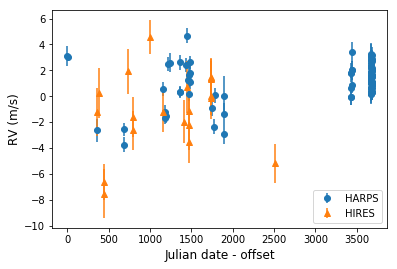

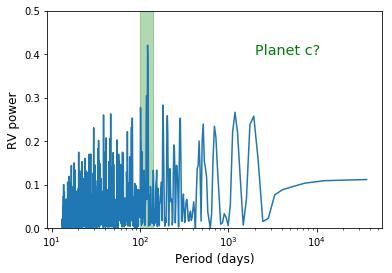

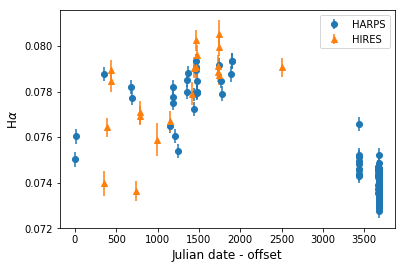

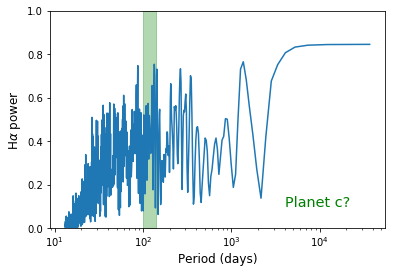

In [2]:
# Plot RV and periodogram
xpts = [101, 106, 111, 116, 121, 126, 131, 136, 141]
ypts = np.ones(9)
plt.figure()
plt.errorbar(date, rv, yerr=rverr, fmt='o', label="HARPS")
plt.errorbar(dateH, rvH, yerr=rverrH, fmt='^', label="HIRES")
plt.legend(loc="lower right")
plt.ylabel("RV (m/s)", fontsize='large')
plt.xlabel("Julian date - offset", fontsize="large")
plt.figure()
plt.plot(1./xiR, powR)
plt.fill_between(xpts, ypts, color="g", alpha=0.3)
plt.ylim([0,0.5])
plt.ylabel("RV power", fontsize="large")
plt.xlabel("Period (days)", fontsize="large")
plt.text(2000,0.4,"Planet c?", color="g", fontsize="x-large")
plt.xscale("log")
plt.figure()
plt.errorbar(date, ha, yerr=haerr, fmt='o', label="HARPS")
plt.errorbar(dateH, haH, yerr=haerrH, fmt='^', label="HIRES")
plt.legend(loc="upper right")
plt.ylabel(r"H$\alpha$", fontsize='large')
plt.xlabel("Julian date - offset", fontsize="large")
plt.figure()
plt.plot(1./xiH, powH)
plt.fill_between(xpts, ypts, color="g", alpha=0.3)
plt.ylim([0,1.])
plt.ylabel(r"H$\alpha$ power", fontsize="large")
plt.xlabel("Period (days)", fontsize="large")
plt.text(4000,0.1,"Planet c?", color="g", fontsize="x-large")
plt.xscale("log")

In [3]:
# To install george: $ conda install -c conda-forge george
# Most of this code is borrowed from a tutorial in the george documentation:
# https://george.readthedocs.io/en/latest/tutorials/hyper/
from george import kernels
from george import GP
from george import modeling
from scipy.optimize import minimize
from scipy.optimize import Bounds

'''Initial guesses for the hyperparameters that give reasonable
converged values--DO NOT DELETE'''

lt_constant = 0.0003
lt_metric = 1500000.


# Create the kernels
k = lt_constant * kernels.ExpSquaredKernel(metric=lt_metric)


# Trivial functions that return the LN white noise VARIANCE.
# Note: I'm not 100% sure I'm treating the measurement uncertainties correctly.
def whitenoise_RV(time):
    return np.log(allRVerr**2)

def whitenoise_ha(time):
    return np.log(allhaerr**2)

# Initialize the Gaussian processes 
# H-Alpha
gp = GP(k, fit_kernel=True, mean=np.mean(allha), \
        white_noise=modeling.CallableModel(whitenoise_ha, gradient=None))

# Function that takes concatenated vector containing BOTH sets of GP
# parameters and separates it into two, one for each GP
def split_par_vec(par_vec):
    lt_amp = par_vec[0]
    lt_metric = par_vec[1]
    pars = [lt_amp, lt_metric]
    return pars

# Function that takes the two parameter vectors and turns them
# into one master parameter vector
def make_par_vec(pars):
    lt_amp = pars[0]
    lt_metric = pars[1]
    
    master_pars = [lt_amp, lt_metric]
    return master_pars

# Set reasonable boundaries for each hyperparameter
# Bounds order is same as parameter order: longterm amplitude, longterm metric
lower_bounds = [-20., 14.2]
upper_bounds = [0., 35.]

# Create a Bounds object that will restrict minimize to values within
# the boundaries
par_bounds = Bounds(lower_bounds, upper_bounds)

# Define the objective function that will be used to evaluate the goodness
# of the fitted hyperparameters (negative log-likelihood in this case)

#H-Alpha
def nll(gpPars):
    p = split_par_vec(gpPars)
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(allha, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# You need to compute both GPs before starting the optimization.
gp.compute(alldates)

# Combine the parameter vectors for both Gaussian processes into
# one (objective function sent to minimize must have only one
# input vector)
pars = gp.get_parameter_vector()
allpars = make_par_vec(pars)
print("Master parameter vector:", allpars)

# Print the initial ln-likelihood
print("Initial ln-likelihood:", -nll(allpars))

# Run the optimization routine. I DON'T THINK USING george's 
# GRAD_LOG_LIKELIHOOD FUNCTION WILL WORK HERE BECAUSE PERIOD AND 
# DECORRELATION TIMESCALE WILL HAVE DIFFERENT GRADIENTS IN THE 
# HALPHA AND RV PARAMETER SETS.
# results = minimize(nll, allpars, jac=grad_nll, method="L-BFGS-B")
results = minimize(nll, allpars, method="TNC", bounds=par_bounds, \
                   options={'maxiter':3000, 'ftol':1.0e-8, 'xtol':1.0e-9, \
                           'gtol':1.0e-8})

# Update the kernels, print the final log-likelihood and results
results_ha = split_par_vec(results.x)
final_loglike = -nll(results.x)
npts = len(alldates)
npars = len(allpars)
bic = np.log(npts) * npars - 2.*final_loglike
print("Final ln-likelihood:", final_loglike)
print(results)
gp.set_parameter_vector(results_ha)
print("\nBayesian information criterion: %4.2f" % bic)

Master parameter vector: [-8.111728083308073, 14.22097566607244]
Initial ln-likelihood: 467.80160545962485
Final ln-likelihood: 475.83720150239935
     fun: -475.83720150239935
     jac: array([ -8.81314577, 115.61138535])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 13
     nit: 3
  status: 0
 success: True
       x: array([ 0. , 14.2])

Bayesian information criterion: -942.24


In [4]:

print("Long-term drift metric: %8.2f days squared" % np.exp(results.x[1]))
print("Long-term drift timescale (sqrt of metric): %8.2f days" % np.sqrt(np.exp(results.x[1])))

print("Constant long-term drift kernel multiplier: %0.6f" % np.exp(results.x[0]))
print("Sqrt of constant long-term drift kernel multiplier (physically meaningful): %0.6f" % np.sqrt(np.exp(results.x[0])), '\n')

Long-term drift metric: 1468864.19 days squared
Long-term drift timescale (sqrt of metric):  1211.97 days
Constant long-term drift kernel multiplier: 1.000000
Sqrt of constant long-term drift kernel multiplier (physically meaningful): 1.000000 



In [5]:
import emcee

# The same boundaries used in minimize will define the edges of uniform
# prior windows
def lnprior(pars):
    for i in range(len(pars)):
        if ((pars[i] < lower_bounds[i]) or (pars[i] > upper_bounds[i])):
            return -np.inf
    return 0.

# The full log-probability function, including priors
def lnprob(pars):
    ll = -nll(pars)
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ll

# Run the Gaussian processes again
gp.compute(alldates)
print("Computed the Gaussian processes")

# Set up the sampler.
nwalkers, ndim = 100, len(allpars)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
pstart = results.x
p0 = pstart + 1.0e-4 * np.random.randn(nwalkers, ndim)
# Use smaller starting distribution in parameter space for tiny numbers: 
# constants multiplying the Halpha exp2 kernels

print("Running burn-in")
nburn = 1000
p0, _, _ = sampler.run_mcmc(p0, nburn)

print("Running production chain")
nproduce = 2000
sampler.run_mcmc(p0, nproduce)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Computed the Gaussian processes
Running burn-in


/Users/student/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/student/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Running production chain
Mean acceptance fraction: 0.593


Text(0,0.5,'H-alpha')

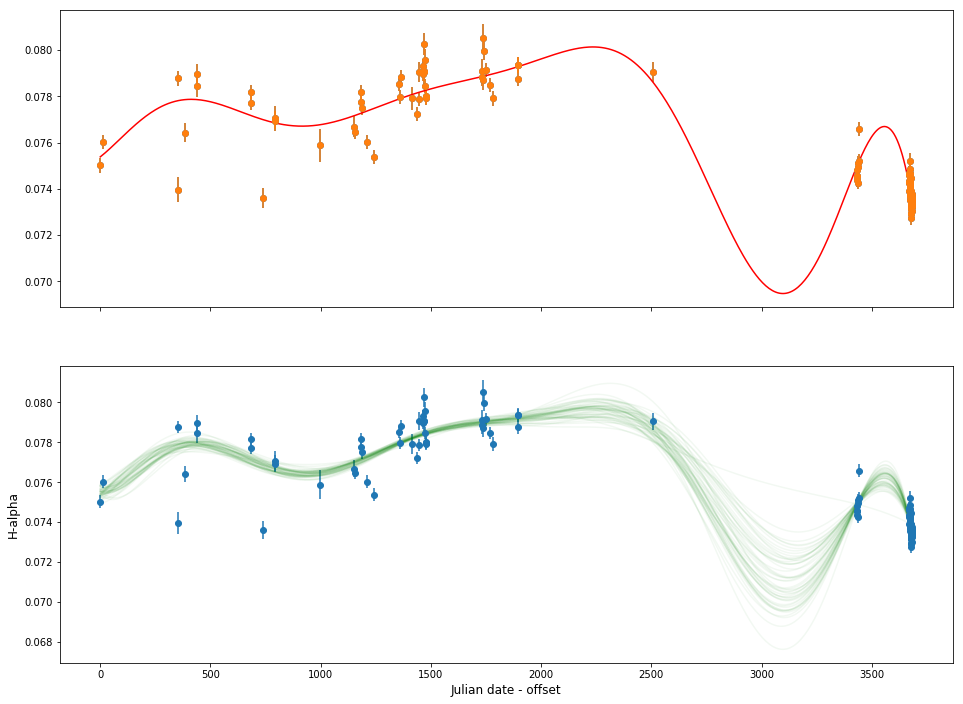

In [6]:
# Make a flat chain of samples with the initial burn-in discarded
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

#set up figure for 5 individual plots
fig, (ax0, ax1) = plt.subplots(2, sharex=True, figsize=(16,12))
tt = np.linspace(alldates[0], alldates[-1], 501, endpoint=True)

# plot individual GPs to check if they are hitting the data
# Choose a sample
n = np.random.randint(0, samples.shape[0])
gp.set_parameter_vector(samples[n])
ax0.plot(tt, gp.sample_conditional(allha, tt), "r")
ax0.errorbar(alldates, allha, yerr=allhaerr, fmt='o')



for i in range(50):
    # Choose a sample
    n = np.random.randint(0, samples.shape[0])
    gp.set_parameter_vector(samples[n])
    # Plot a single sample.
    ax1.plot(tt, gp.sample_conditional(allha, tt), "g", alpha=0.05)
    
# Plot the real data
ax0.errorbar(alldates, allha, yerr=allhaerr, fmt='o')
ax1.errorbar(alldates, allha, yerr=allhaerr, fmt='o')


ax1.set_xlabel("Julian date - offset", fontsize='large')
ax1.set_ylabel("H-alpha", fontsize = 'large')

